In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Various tests on individual functions

## Time Variable s

In [2]:
t = fct.s_of_z(4)
print(type(t), t)

<class 'numpy.float64'> -39446596596.43442


## Critical Density

In [3]:
crit = fct.rho_crit(0)
print('Check if this matches critical density of universe today:')
print(crit.to(unit.kg/unit.m**3))

Check if this matches critical density of universe today:
8.598814256622896e-27 kg / m3


## Unit Conversion Tests

In [4]:
print(my.T_nu.to(unit.eV, unit.temperature_energy()))

0.00016803799861183098 eV


## Derivative vector values

In [5]:
z = 0
x_i = np.array([1.,2.,3.])*unit.km

t2 = fct.dPsi_dxi_NFW(x_i, z, my.rho0_NFW, my.Mvir_NFW)
print(type(t2), t2)

<class 'astropy.units.quantity.Quantity'> [-14867.28345853 -29734.56691707 -44601.8503756 ] kpc / s2


## Fermi-Dirac plot and Initial Momentum Tests

In [6]:
# Ringwald & Wong (2004) take initial momentum values in the range
# 0.01 <= p/T_nu_0 <= 13 , covering more than 99.9% of the distribution.

# neutrino mass
m_nu = 0.05 * unit.eV  # in natural units
m_nu_kg = m_nu.to(unit.kg, unit.mass_energy())  # in SI units

u0 = 3000.*unit.km/unit.s
p0 = u0 * m_nu_kg

to_eV = 1/(5.3442883e-28)
p0 = p0.to(unit.kg*unit.m/unit.s).value * to_eV * unit.eV
print(p0)

0.0005003459267797823 eV


In [7]:
def convert_ratio(pT_ratio):

    T_in_eV = my.T_nu.to(unit.eV, unit.temperature_energy())
    conversion_unit = (1/5.3442883e-28) * const.k_B.value * T_in_eV.value

    return 1/(pT_ratio / conversion_unit)

print(convert_ratio(0.01))
print(convert_ratio(13.))

lower = 13*const.c
print(lower.to(unit.km/unit.s))

434.1111140007657
0.3339316261544352
3897301.954 km / s


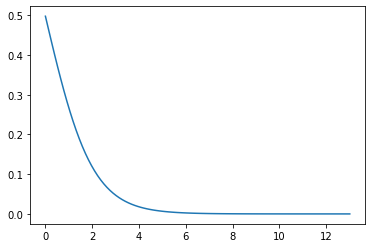

In [8]:
def FDplot(p_by_T):

    return 1 / (np.exp(p_by_T) + 1)

ratio_range = np.linspace(0.01,13,100)

plt.plot(ratio_range, FDplot(ratio_range))

## Initial velocity limits

In [9]:
# conversion factor for limits
cf = 5.3442883e-28 / CC.NU_MASS.to(unit.kg, unit.mass_energy()).value
T_nu_eV = my.T_nu.to(unit.eV, unit.temperature_energy()).value

# limits on velocity
lower = 0.01*T_nu_eV*cf
upper = 10*T_nu_eV*cf

print(lower, upper/const.c.value)

!# should be order of O(1000) km/s

10075.309278122077 0.03360761423198337


# Investigating the shape of the final number density curve

## Relation of p0 to p1

In [15]:
# Amount of simulated neutrinos
Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)

# load initial and final velocity
u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0,3:6] for Nr in Ns]
u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1,3:6] for Nr in Ns]

print(np.array(u1))


# intermediate arrays
a0 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u0)])
a1 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u1)])

print(np.array(a1)-np.array(a0))

# convert mass(es) from eV to kg
m_nu_eV = 0.05 * unit.eV
m_nu_kg = m_nu_eV.to(unit.kg, unit.mass_energy())

p_unit = unit.kg*unit.kpc/unit.s
p0, p1 = a0 * m_nu_kg.value * p_unit, a1 * m_nu_kg.value * p_unit

# convert momenta from kg*kpc/s to eV
to_eV = 1/(5.3442883e-28)
p0 = p0.to(unit.kg*unit.m/unit.s).value * to_eV
p1 = p1.to(unit.kg*unit.m/unit.s).value * to_eV

# they are already sorted
order = p0.argsort()


plt.plot(p0, p1)

(50, 6)
(50,)
-0.0022636347321167705
-0.002262906450596347
3.054419721593149e-07


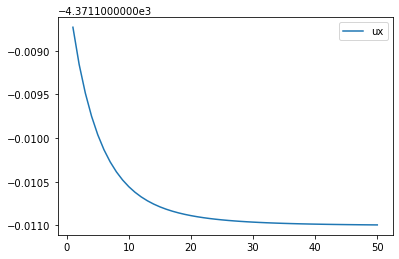

In [13]:
raw = np.load(f'neutrino_vectors/nu_6.npy')*unit.kpc/unit.s
u_1nu = raw.to(unit.km/unit.s).value

print(u_1nu.shape)

ux = u_1nu[:,3]
uy = u_1nu[:,4]
uz = u_1nu[:,5]

mags = np.array([np.sqrt(np.sum(u**2)) for u in u_1nu[:, 3:6]])
print(mags.shape)

s = np.linspace(1,50,50)

print(ux[-1]-ux[0])
print(uy[-1]-uy[0])
print(uz[-1]-uz[0])
plt.plot(s, ux, label='ux')
# plt.plot(s, uy, label='uy')
# plt.plot(s, uz, label='uz')
plt.legend()

#! Velocities do not change...

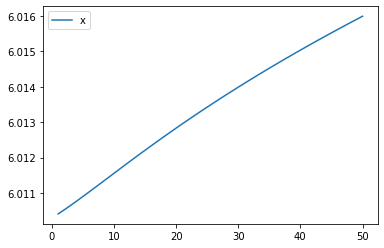

In [16]:
u_1nu = raw.value

x = u_1nu[:,0]
y = u_1nu[:,1]
z = u_1nu[:,2]

plt.plot(s, x, label='x')
# plt.plot(s, y, label='y')
# plt.plot(s, z, label='z')
plt.legend()

#! Positions change with opposite sign to velocity, since we integrate
#! back in time.